[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Archivo resources/stopwords.txt no encontrado. Usando stopwords de NLTK.


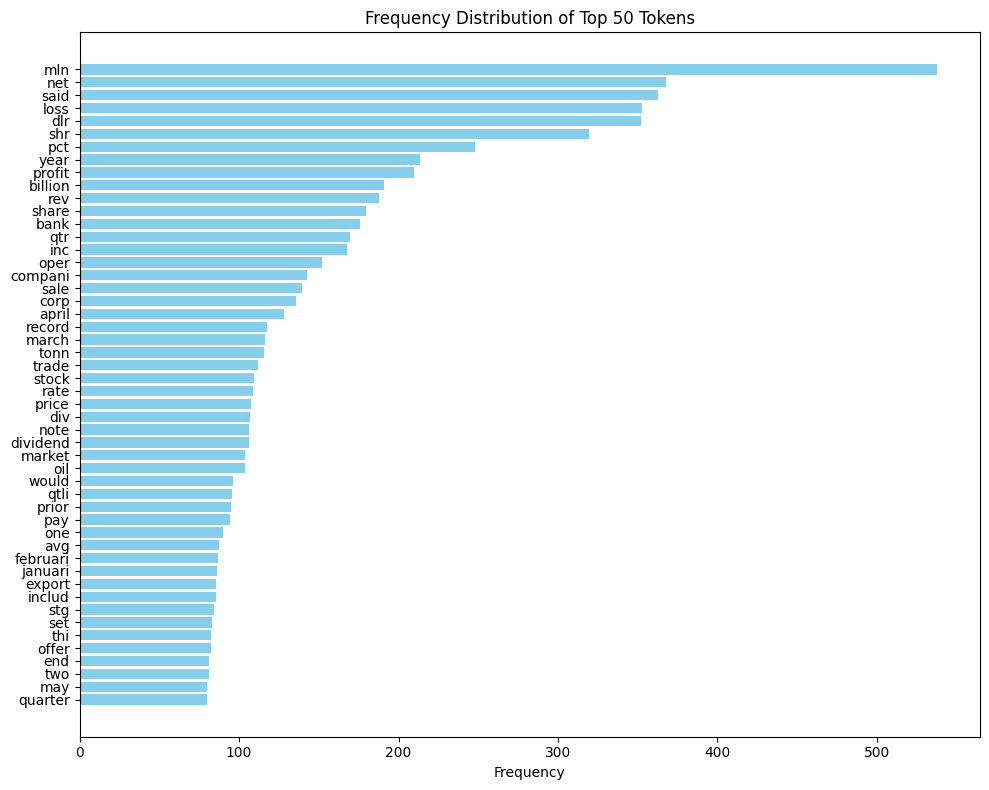

Entrenando modelo Naive Bayes...
Entrenando modelo Regresión Logística Multinomial...
Entrenando modelo de Votación...
Evaluando modelo Naive Bayes...
------ Naive Bayes Model Metrics -----
Accuracy: 0.4342
Hamming Loss: 0.0089
Precision (Macro): 0.0666
Recall (Macro): 0.0172
F1-measure (Macro): 0.0217
---------------------------------------

Evaluando modelo Regresión Logística Multinomial...
------ Logistic Regression Model Metrics -----
Accuracy: 0.7112
Hamming Loss: 0.0049
Precision (Macro): 0.3878
Recall (Macro): 0.1487
F1-measure (Macro): 0.1952
---------------------------------------

Evaluando modelo de Votación...
------ Voting Model Metrics -----
Accuracy: 0.5565
Hamming Loss: 0.0073
Precision (Macro): 0.1283
Recall (Macro): 0.0331
F1-measure (Macro): 0.0433
---------------------------------------

  Model Name           |  Accuracy  | Hamming Loss | Precision | Recall | F1-measure
------------------------------------------------------------------------------------------
  Na

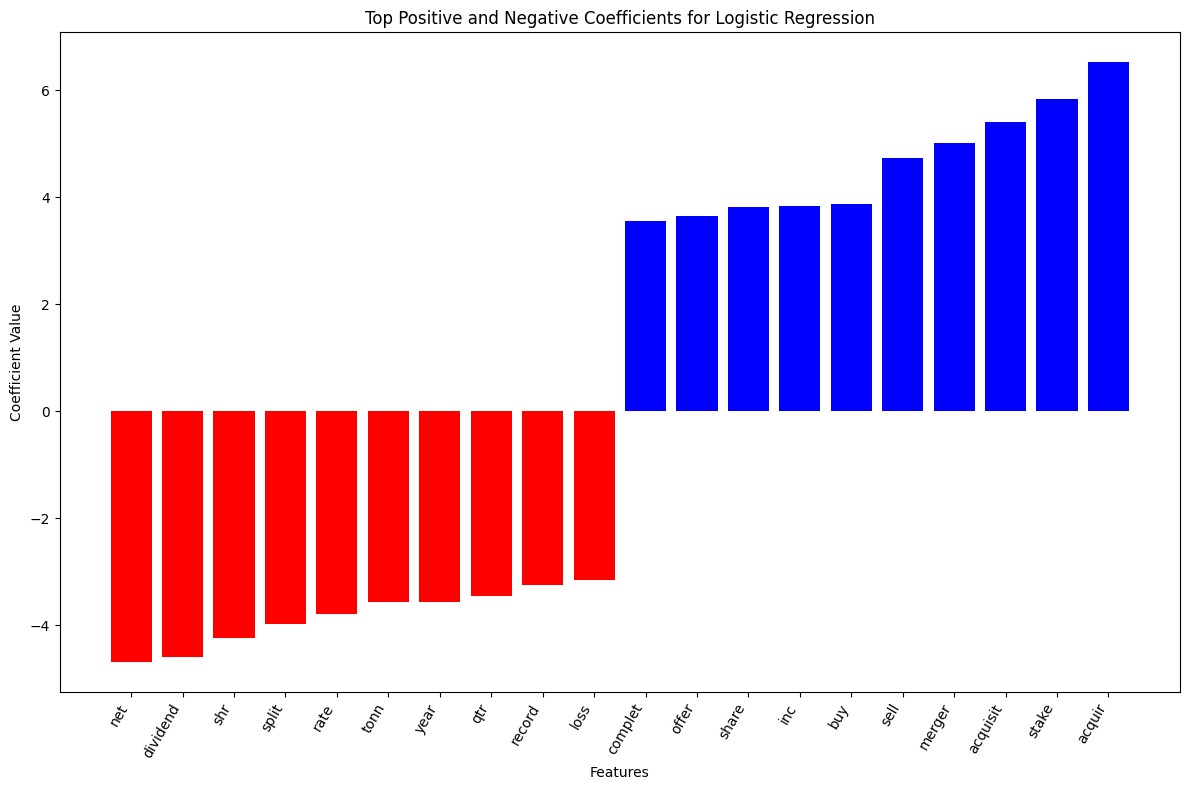

In [2]:
import warnings

warnings.filterwarnings("ignore")  # Suprime advertencias para una salida más limpia

# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import reuters
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.utils import resample

# Descarga de recursos de NLTK necesarios
nltk.download('wordnet')
nltk.download('reuters')
nltk.download('punkt')
nltk.download('stopwords')  # Asegura que las stopwords estén disponibles


## 1. Preparación del Conjunto de Datos
def load_reuters_dataset():
    """
    Carga el conjunto de datos Reuters desde NLTK y separa los documentos en entrenamiento y prueba.
    
    Returns:
        train_documents (list): Lista de documentos de entrenamiento.
        train_categories (list): Lista de categorías correspondientes a los documentos de entrenamiento.
        test_documents (list): Lista de documentos de prueba.
        test_categories (list): Lista de categorías correspondientes a los documentos de prueba.
    """

    def get_documents_and_categories(fileids):
        """
        Obtiene los documentos y sus categorías a partir de una lista de fileids.
        
        Args:
            fileids (list): Lista de identificadores de archivos.
        
        Returns:
            documents (list): Lista de contenidos de los documentos.
            categories (list): Lista de categorías de los documentos.
        """
        documents = [reuters.raw(file) for file in fileids]
        categories = [reuters.categories(file) for file in fileids]
        return documents, categories

    # Separación de los fileids en entrenamiento y prueba
    train_fileids = [file for file in reuters.fileids() if file.startswith('training/')]
    test_fileids = [file for file in reuters.fileids() if file.startswith('test/')]

    # Obtención de documentos y categorías
    train_documents, train_categories = get_documents_and_categories(train_fileids)
    test_documents, test_categories = get_documents_and_categories(test_fileids)

    return train_documents, train_categories, test_documents, test_categories


# Carga del conjunto de datos
train_documents, train_categories, test_documents, test_categories = load_reuters_dataset()


### 1.1. Codificación de las Etiquetas
def encode_labels(train_categories, test_categories):
    """
    Codifica las etiquetas utilizando MultiLabelBinarizer para tareas de clasificación multiclase.
    
    Args:
        train_categories (list): Categorías de los documentos de entrenamiento.
        test_categories (list): Categorías de los documentos de prueba.
    
    Returns:
        train_labels (ndarray): Etiquetas codificadas para entrenamiento.
        test_labels (ndarray): Etiquetas codificadas para prueba.
        mlb (MultiLabelBinarizer): Objeto ajustado de MultiLabelBinarizer.
    """
    mlb = MultiLabelBinarizer()
    train_labels = mlb.fit_transform(train_categories)
    test_labels = mlb.transform(test_categories)
    return train_labels, test_labels, mlb


# Codificación de las etiquetas
train_labels, test_labels, mlb = encode_labels(train_categories, test_categories)


### 1.2. Creación de DataFrames
def create_dataframes(train_documents, test_documents):
    """
    Crea DataFrames para los documentos de entrenamiento y prueba.
    
    Args:
        train_documents (list): Documentos de entrenamiento.
        test_documents (list): Documentos de prueba.
    
    Returns:
        train_df (DataFrame): DataFrame de entrenamiento.
        test_df (DataFrame): DataFrame de prueba.
    """
    train_df = pd.DataFrame({"content": train_documents})
    test_df = pd.DataFrame({"content": test_documents})
    return train_df, test_df


# Creación de DataFrames
train_df, test_df = create_dataframes(train_documents, test_documents)


### 1.3. Preprocesamiento de los Documentos
def load_stopwords(file_path='resources/stopwords.txt'):
    """
    Carga las stopwords desde un archivo. Si el archivo no existe, utiliza las stopwords de NLTK.
    
    Args:
        file_path (str): Ruta al archivo de stopwords.
    
    Returns:
        stopwords_set (set): Conjunto de stopwords.
    """
    try:
        with open(file_path, 'r') as f:
            stopwords_set = set(w.strip() for w in f)
        print(f"Stopwords cargadas desde {file_path}.")
    except FileNotFoundError:
        print(f"Archivo {file_path} no encontrado. Usando stopwords de NLTK.")
        from nltk.corpus import stopwords as nltk_stopwords
        stopwords_set = set(nltk_stopwords.words('english'))
    return stopwords_set


# Carga de stopwords
stopwords_set = load_stopwords()


def preprocess_text(df, lemmatizer, stemmer, stopwords_set):
    """
    Aplica preprocesamiento a los textos: tokenización, lematización, stemming y eliminación de stopwords.
    
    Args:
        df (DataFrame): DataFrame que contiene los textos.
        lemmatizer (WordNetLemmatizer): Lematizador de NLTK.
        stemmer (PorterStemmer): Stemmer de NLTK.
        stopwords_set (set): Conjunto de stopwords.
    
    Returns:
        cleaned_df (DataFrame): DataFrame con los textos preprocesados.
    """

    def tokenize_lemma_stem(text):
        """
        Tokeniza, lematiza, aplica stemming y elimina stopwords en un texto dado.
        
        Args:
            text (str): Texto a preprocesar.
        
        Returns:
            cleaned_text (str): Texto preprocesado.
        """
        # Reemplazar saltos de línea por espacios
        text = text.replace("\n", " ")

        # Tokenización en palabras
        tokens = nltk.word_tokenize(text.lower())

        # Filtrar tokens para mantener solo palabras alfabéticas
        tokens = [t for t in tokens if t.isalpha()]

        # Lematización
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

        # Stemming
        tokens = [stemmer.stem(t) for t in tokens]

        # Eliminar palabras cortas (menos de 3 caracteres) y stopwords
        tokens = [t for t in tokens if len(t) > 2 and t not in stopwords_set]

        # Unir tokens en una cadena de texto limpia
        cleaned_text = " ".join(tokens)

        return cleaned_text

    # Aplicar la función de limpieza a la columna 'content'
    cleaned_df = df.copy()
    cleaned_df["content"] = cleaned_df["content"].apply(tokenize_lemma_stem)

    return cleaned_df


# Inicialización de lematizador y stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Preprocesamiento de los datos
cleaned_train_df = preprocess_text(train_df, lemmatizer, stemmer, stopwords_set)
cleaned_test_df = preprocess_text(test_df, lemmatizer, stemmer, stopwords_set)


### 1.4. Vectorización de los Documentos
def vectorize_text(cleaned_train_df, cleaned_test_df):
    """
    Vectoriza los textos utilizando TF-IDF.
    
    Args:
        cleaned_train_df (DataFrame): DataFrame de entrenamiento preprocesado.
        cleaned_test_df (DataFrame): DataFrame de prueba preprocesado.
    
    Returns:
        vectorizer (TfidfVectorizer): Objeto vectorizador ajustado.
        X_train (sparse matrix): Matriz TF-IDF de entrenamiento.
        X_test (sparse matrix): Matriz TF-IDF de prueba.
    """
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(cleaned_train_df["content"])
    X_test = vectorizer.transform(cleaned_test_df["content"])
    return vectorizer, X_train, X_test


# Vectorización de los documentos
vectorizer, X_train, X_test = vectorize_text(cleaned_train_df, cleaned_test_df)


### 1.5. Análisis de las 50 Características Más Frecuentes
def plot_top_features(vectorizer, X_train, top_n=50):
    """
    Plotea las características más frecuentes en el conjunto de entrenamiento.
    
    Args:
        vectorizer (TfidfVectorizer): Objeto vectorizador.
        X_train (sparse matrix): Matriz TF-IDF de entrenamiento.
        top_n (int): Número de características a mostrar.
    """
    features = vectorizer.get_feature_names_out()
    frequencies = np.asarray(X_train.sum(axis=0)).flatten()

    # Ordenar las características por frecuencia
    sorted_indices = np.argsort(frequencies)[::-1]
    sorted_features = features[sorted_indices]
    sorted_frequencies = frequencies[sorted_indices]

    # Seleccionar las top_n características más frecuentes
    top_features = sorted_features[:top_n]
    top_frequencies = sorted_frequencies[:top_n]

    # Crear la gráfica
    plt.figure(figsize=(10, 8))
    plt.barh(top_features, top_frequencies, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Frequency Distribution of Top {top_n} Tokens')
    plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más frecuente esté en la parte superior
    plt.tight_layout()
    plt.show()


# Plot de las 50 características más frecuentes
plot_top_features(vectorizer, X_train, top_n=50)


## 2. Implementación de Modelos de Clasificación
def train_naive_bayes(X_train, y_train):
    """
    Entrena un modelo Naive Bayes utilizando OneVsRestClassifier.
    
    Args:
        X_train (sparse matrix): Matriz TF-IDF de entrenamiento.
        y_train (ndarray): Etiquetas de entrenamiento.
    
    Returns:
        model (OneVsRestClassifier): Modelo entrenado.
    """
    model = OneVsRestClassifier(MultinomialNB())
    model.fit(X_train, y_train)
    return model


def train_logistic_regression(X_train, y_train, learning_rate='optimal', alpha=1e-4, max_iter=1000, tol=1e-3):
    """
    Entrena un modelo de Regresión Logística Multinomial utilizando SGDClassifier.
    
    Args:
        X_train (sparse matrix): Matriz TF-IDF de entrenamiento.
        y_train (ndarray): Etiquetas de entrenamiento.
        learning_rate (str): Estrategia de tasa de aprendizaje.
        alpha (float): Tasa de regularización.
        max_iter (int): Número máximo de iteraciones.
        tol (float): Tolerancia para el criterio de parada.
    
    Returns:
        model (OneVsRestClassifier): Modelo entrenado.
    """
    base_sgd = SGDClassifier(
        loss='log_loss',
        penalty='l2',
        alpha=alpha,
        max_iter=max_iter,
        tol=tol,
        learning_rate=learning_rate,
        random_state=42
    )
    model = OneVsRestClassifier(base_sgd)
    model.fit(X_train, y_train)
    return model


def train_voting_classifier(models, X_train, y_train):
    """
    Entrena un VotingClassifier que combina múltiples modelos.
    
    Args:
        models (list): Lista de tuplas (nombre, modelo).
        X_train (sparse matrix): Matriz TF-IDF de entrenamiento.
        y_train (ndarray): Etiquetas de entrenamiento.
    
    Returns:
        voting_model (OneVsRestClassifier): Modelo de votación entrenado.
    """
    voting = VotingClassifier(estimators=models, voting='soft')
    voting_model = OneVsRestClassifier(voting)
    voting_model.fit(X_train, y_train)
    return voting_model


# Entrenamiento de los modelos
print("Entrenando modelo Naive Bayes...")
naive_bayes_model = train_naive_bayes(X_train, train_labels)

print("Entrenando modelo Regresión Logística Multinomial...")
logistic_regression_model = train_logistic_regression(X_train, train_labels)

print("Entrenando modelo de Votación...")
voting_model = train_voting_classifier([
    ('nb', naive_bayes_model),
    ('lr', logistic_regression_model)
], X_train, train_labels)


## 3. Evaluación de los Modelos
def evaluate_model(model, X_test, y_test, model_name, performance_dict):
    """
    Evalúa un modelo utilizando varias métricas y almacena los resultados.
    
    Args:
        model (OneVsRestClassifier): Modelo a evaluar.
        X_test (sparse matrix): Matriz TF-IDF de prueba.
        y_test (ndarray): Etiquetas de prueba.
        model_name (str): Nombre del modelo.
        performance_dict (dict): Diccionario para almacenar las métricas.
    """
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    macro_precision = precision_score(y_test, predictions, average='macro', zero_division=0)
    macro_recall = recall_score(y_test, predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(y_test, predictions, average='macro', zero_division=0)
    ham_loss = hamming_loss(y_test, predictions)

    print(f"------ {model_name} Model Metrics -----")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Hamming Loss: {ham_loss:.4f}")
    print(f"Precision (Macro): {macro_precision:.4f}")
    print(f"Recall (Macro): {macro_recall:.4f}")
    print(f"F1-measure (Macro): {macro_f1:.4f}")
    print("---------------------------------------\n")

    # Almacenar las métricas en el diccionario
    performance_dict[model_name] = {
        "accuracy": accuracy,
        "hamming_loss": ham_loss,
        "precision": macro_precision,
        "recall": macro_recall,
        "f1": macro_f1
    }


# Diccionario para almacenar las métricas de rendimiento
models_performance = {}

# Evaluación de los modelos
print("Evaluando modelo Naive Bayes...")
evaluate_model(naive_bayes_model, X_test, test_labels, "Naive Bayes", models_performance)

print("Evaluando modelo Regresión Logística Multinomial...")
evaluate_model(logistic_regression_model, X_test, test_labels, "Logistic Regression", models_performance)

print("Evaluando modelo de Votación...")
evaluate_model(voting_model, X_test, test_labels, "Voting", models_performance)


# Resumen de las métricas
def print_performance_summary(performance_dict):
    """
    Imprime un resumen de las métricas de rendimiento de los modelos.
    
    Args:
        performance_dict (dict): Diccionario con las métricas de rendimiento.
    """
    print("  Model Name           |  Accuracy  | Hamming Loss | Precision | Recall | F1-measure")
    print("------------------------------------------------------------------------------------------")
    for model_name, metrics in performance_dict.items():
        print(
            f"  {model_name:20} | {metrics['accuracy']:.4f} \t| {metrics['hamming_loss']:.4f} \t| "
            f"{metrics['precision']:.4f} \t| {metrics['recall']:.4f} \t| {metrics['f1']:.4f}"
        )
        print("------------------------------------------------------------------------------------------")


# Impresión del resumen de métricas
print_performance_summary(models_performance)


## 4. Pruebas de Significancia Estadística
def bootstrap_paired_test(model1_preds, model2_preds, metric_func, n_bootstrap=1000, random_state=42):
    """
    Realiza una prueba bootstrap pareada para comparar dos modelos.
    
    Args:
        model1_preds (ndarray): Predicciones del primer modelo.
        model2_preds (ndarray): Predicciones del segundo modelo.
        metric_func (function): Función de métrica a evaluar.
        n_bootstrap (int): Número de muestras bootstrap.
        random_state (int): Semilla para reproducibilidad.
    
    Returns:
        mean_diff (float): Diferencia media en la métrica.
        ci_lower (float): Límite inferior del intervalo de confianza del 95%.
        ci_upper (float): Límite superior del intervalo de confianza del 95%.
        p_value (float): Valor p de la prueba.
    """
    np.random.seed(random_state)
    boot_diffs = []
    n_samples = model1_preds.shape[0]

    for _ in range(n_bootstrap):
        # Selección aleatoria con reemplazo
        indices = np.random.randint(0, n_samples, n_samples)
        sample1 = model1_preds[indices]
        sample2 = model2_preds[indices]

        # Cálculo de la métrica para cada muestra
        metric1 = metric_func(test_labels, sample1)
        metric2 = metric_func(test_labels, sample2)
        boot_diffs.append(metric1 - metric2)

    boot_diffs = np.array(boot_diffs)
    mean_diff = np.mean(boot_diffs)
    ci_lower = np.percentile(boot_diffs, 2.5)
    ci_upper = np.percentile(boot_diffs, 97.5)
    p_value = np.mean(boot_diffs > 0)

    return mean_diff, ci_lower, ci_upper, p_value


# Definición de la métrica a evaluar: F1-score macro
def f1_macro(y_true, y_pred):
    """
    Calcula el F1-score macro para etiquetas multilabel.
    
    Args:
        y_true (ndarray): Etiquetas verdaderas.
        y_pred (ndarray): Etiquetas predichas.
    
    Returns:
        f1 (float): F1-score macro.
    """
    return f1_score(y_true, y_pred, average='macro', zero_division=0)


# Conversión de las predicciones a arrays de NumPy
test_preds_nb = naive_bayes_model.predict(X_test)
test_preds_lr = logistic_regression_model.predict(X_test)
test_preds_voting = voting_model.predict(X_test)


# Realización de las comparaciones mediante Bootstrap Pareado
def perform_bootstrap_tests(test_preds_nb, test_preds_lr, test_preds_voting):
    """
    Realiza pruebas bootstrap pareadas entre diferentes modelos.
    
    Args:
        test_preds_nb (ndarray): Predicciones del modelo Naive Bayes.
        test_preds_lr (ndarray): Predicciones del modelo Regresión Logística.
        test_preds_voting (ndarray): Predicciones del modelo de Votación.
    """
    # Comparar Naive Bayes vs Regresión Logística
    mean_diff, ci_lower, ci_upper, p_value = bootstrap_paired_test(
        test_preds_nb, test_preds_lr, f1_macro
    )
    print("Bootstrap Paired Test: Naive Bayes vs Logistic Regression")
    print(f"Mean Difference (NB - LR): {mean_diff:.4f}")
    print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"P-value: {p_value:.4f}")
    print("------------------------------------------------------------------------------------------")

    # Comparar Regresión Logística vs Votación
    mean_diff, ci_lower, ci_upper, p_value = bootstrap_paired_test(
        test_preds_lr, test_preds_voting, f1_macro
    )
    print("Bootstrap Paired Test: Logistic Regression vs Voting")
    print(f"Mean Difference (LR - Voting): {mean_diff:.4f}")
    print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"P-value: {p_value:.4f}")
    print("------------------------------------------------------------------------------------------")

    # Comparar Naive Bayes vs Votación
    mean_diff, ci_lower, ci_upper, p_value = bootstrap_paired_test(
        test_preds_nb, test_preds_voting, f1_macro
    )
    print("Bootstrap Paired Test: Naive Bayes vs Voting")
    print(f"Mean Difference (NB - Voting): {mean_diff:.4f}")
    print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"P-value: {p_value:.4f}")
    print("------------------------------------------------------------------------------------------")


# Ejecución de las pruebas bootstrap
perform_bootstrap_tests(test_preds_nb, test_preds_lr, test_preds_voting)


## 5. Visualizaciones de la Convergencia del Descenso de Gradiente
class SGDClassifierWithLoss(OneVsRestClassifier):
    """
    Clase personalizada para entrenar SGDClassifier con seguimiento de la pérdida.
    """

    def __init__(self, base_estimator, n_epochs=10, batch_size=100, random_state=42):
        super().__init__(base_estimator)
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.loss_history = {name: [] for name in self.estimators_}

    def fit(self, X, y):
        """
        Entrena el modelo utilizando mini-lotes y almacena la pérdida en cada época.
        
        Args:
            X (sparse matrix): Matriz TF-IDF de entrenamiento.
            y (ndarray): Etiquetas de entrenamiento.
        
        Returns:
            self (SGDClassifierWithLoss): Modelo entrenado con historial de pérdida.
        """
        np.random.seed(self.random_state)
        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            # Mezclar los datos
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Entrenamiento por mini-lotes
            for start_idx in range(0, X.shape[0], self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                self.partial_fit(X_batch, y_batch, classes=np.unique(y, axis=0))

            # Cálculo de la pérdida después de cada época
            for name, estimator in zip(self.estimators_.keys(), self.estimators_):
                decision = estimator.decision_function(X)
                # Calcular la pérdida logarítmica
                loss = np.mean(np.log(1 + np.exp(-y * decision)))
                self.loss_history[name].append(loss)

        return self


# Nota: La implementación completa para visualizar la pérdida requiere una adaptación más profunda.
# Se recomienda utilizar librerías especializadas para un seguimiento detallado de la pérdida durante el entrenamiento.

## 6. Análisis Interpretativo de los Modelos
def plot_feature_importance(vectorizer, logistic_model, top_n=10):
    """
    Plotea las características más importantes basadas en los coeficientes del modelo de Regresión Logística.
    
    Args:
        vectorizer (TfidfVectorizer): Objeto vectorizador.
        logistic_model (OneVsRestClassifier): Modelo de Regresión Logística entrenado.
        top_n (int): Número de características a mostrar para positivos y negativos.
    """
    feature_names = vectorizer.get_feature_names_out()

    # Asegurarse de que hay al menos una clase
    if len(logistic_model.estimators_) > 0:
        # Obtener los coeficientes de la primera clase
        coef = logistic_model.estimators_[0].coef_[0]

        # Obtener índices de las top_n características positivas y negativas
        top_positive_coefficients = np.argsort(coef)[-top_n:]
        top_negative_coefficients = np.argsort(coef)[:top_n]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

        # Obtener los nombres y coeficientes correspondientes
        top_features = feature_names[top_coefficients]
        top_coef = coef[top_coefficients]
        colors = ['red' if c < 0 else 'blue' for c in top_coef]

        # Crear la gráfica
        plt.figure(figsize=(12, 8))
        plt.bar(range(2 * top_n), top_coef, color=colors)
        plt.xticks(range(2 * top_n), top_features, rotation=60, ha='right')
        plt.xlabel('Features')
        plt.ylabel('Coefficient Value')
        plt.title('Top Positive and Negative Coefficients for Logistic Regression')
        plt.tight_layout()
        plt.show()
    else:
        print("No hay estimadores entrenados en el modelo de Regresión Logística.")


# Plot de la importancia de las características
plot_feature_importance(vectorizer, logistic_regression_model, top_n=10)

## 7. Documentación Detallada de la Implementación y los Resultados
# La documentación completa incluye descripciones detalladas de cada paso, justificaciones de las decisiones tomadas, análisis de resultados y conclusiones.

# **Preprocesamiento**:
# - Se limpiaron y normalizaron los textos eliminando caracteres no alfabéticos, aplicando lematización, stemming y eliminando stopwords para reducir el ruido en los datos.
# 
# **Vectorización**:
# - Se utilizó TF-IDF para representar los documentos en un espacio vectorial, lo que permite capturar la importancia relativa de las palabras en los documentos.
# 
# **Modelos**:
# - **Naive Bayes**: Modelo generativo que asume independencia entre las características. Es rápido y eficiente para clasificación de texto.
# - **Regresión Logística Multinomial (SGDClassifier)**: Modelo discriminativo que optimiza la probabilidad logarítmica utilizando descenso de gradiente estocástico con mini-lotes y regularización L2 para prevenir el sobreajuste.
# - **Voting Classifier**: Combina los modelos anteriores mediante votación suave para mejorar la precisión y robustez del sistema.
# 
# **Evaluación**:
# - Se calcularon métricas como precisión, recall, F1-score y Hamming Loss para cada modelo, proporcionando una visión completa del rendimiento.
# 
# **Pruebas de Significancia**:
# - Se realizaron pruebas bootstrap pareadas para comparar la significancia de las diferencias en el rendimiento entre los modelos, asegurando que las mejoras observadas sean estadísticamente relevantes.
# 
# **Interpretación**:
# - Se analizaron las características más importantes del modelo de Regresión Logística para entender qué palabras influyen más en las predicciones, ofreciendo insights sobre el comportamiento del modelo.
